<a href="https://colab.research.google.com/github/josin29999/Brazillian-E-Commerce/blob/main/Unsupervising_Learning_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install library

In [1]:
# installing pandas_ta
!pip install pandas-ta

# installing PyPortfolioOpt
!pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=fe7adca8d450cd7647d3087001284b3546b4e60abeb7b0f427189b88e8b79911
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 413.5 kB/s eta 0:00:00


# Download 500 S&P dataset

In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-10-30'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
            start=start_date,
            end=end_date).stack()


[*********************100%%**********************]  503 of 503 completed


In [3]:
# Make date & ticker become index
df.index.names = ['date', 'ticker']

# lowering columns name
df.columns = df.columns.str.lower()

df

adj close       close        high         low        open  \
date       ticker                                                               
2015-11-02 A        36.128700   38.590000   38.619999   37.799999   37.869999   
           AAL      44.313286   46.470001   46.820000   46.200001   46.200001   
           AAPL     27.498980   30.295000   30.340000   29.902500   30.200001   
           ABBV     44.862247   63.380001   64.199997   61.439999   61.599998   
           ABT      39.108433   45.430000   45.500000   44.599998   44.880001   
...                       ...         ...         ...         ...         ...   
2023-10-27 YUM     119.440002  119.440002  120.250000  118.279999  119.040001   
           ZBH     103.190002  103.190002  104.809998  102.709999  104.000000   
           ZBRA    207.179993  207.179993  207.559998  201.160004  204.600006   
           ZION     29.095911   29.450001   30.670000   28.980000   30.590000   
           ZTS     155.657318  156.029999  157.929993  155.160004  157.929993   

                        volume  
date       ticker               
2015-11-02 A         1810800.0  
           AAL       6189300.0  
           AAPL    128813200.0  
           ABBV     17008700.0  
           ABT       5477800.0  
...                        ...  
2023-10-27 YUM       2331000.0  
           ZBH       1534500.0  
           ZBRA       565000.0  
           ZION      2498300.0  
           ZTS       2407100.0  

[994050 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [4]:
# garman klass volatility
df['garman_klass_volatility'] = ((np.log(df['high']) - np.log(df['low']))**2)/2-((2*np.log(2)-1)*(((np.log(df['adj close'])) - np.log(df['open']))**2))

# Rsi
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

## rangkaian membuat bolinger bands

In [5]:
# df['bbands']

# Group your data by the 'group' column
grouped = df.groupby('ticker')

# Define a function to calculate Bollinger Bands
def calculate_bbands(x):
    return pandas_ta.bbands(close=np.log1p(x), length=20)

# Apply the custom function to each group and concatenate the results
bbands = grouped['adj close'].apply(calculate_bbands)

# have 2 column named "ticker" & deleting one of them

# reset index level 2
bbands1 = bbands.reset_index(level=2)

# dropping column ticker
bbands2 = bbands1.drop(['ticker'], axis=1)

# reset index "ticker" & date
bbands_fix = bbands2.reset_index()

# reset_index for df
df_ri = df.reset_index()

# merging based date & ticker
df_bb = df_ri.merge(bbands_fix, on=['date', 'ticker'], how='left')

# dropping some bollinger bands that we don't need
df_bb2 = df_bb.drop(['BBB_20_2.0', 'BBP_20_2.0'], axis=1)


dict = {'BBL_20_2.0' : 'bb_low',
        'BBM_20_2.0' : 'bb_mid',
        'BBU_20_2.0' : 'bb_high'}

# call rename () method
df_bb2.rename(columns=dict,
          inplace=True)


# set index 'date' & 'ticker'
df_bb3 = df_bb2.set_index(['date', 'ticker'])

df_bb3

adj close       close        high         low        open  \
date       ticker                                                               
2015-11-02 A        36.128700   38.590000   38.619999   37.799999   37.869999   
           AAL      44.313286   46.470001   46.820000   46.200001   46.200001   
           AAPL     27.498980   30.295000   30.340000   29.902500   30.200001   
           ABBV     44.862247   63.380001   64.199997   61.439999   61.599998   
           ABT      39.108433   45.430000   45.500000   44.599998   44.880001   
...                       ...         ...         ...         ...         ...   
2023-10-27 YUM     119.440002  119.440002  120.250000  118.279999  119.040001   
           ZBH     103.190002  103.190002  104.809998  102.709999  104.000000   
           ZBRA    207.179993  207.179993  207.559998  201.160004  204.600006   
           ZION     29.095911   29.450001   30.670000   28.980000   30.590000   
           ZTS     155.657318  156.029999  157.929993  155.160004  157.929993   

                        volume  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                              
2015-11-02 A         1810800.0                -0.000626        NaN       NaN   
           AAL       6189300.0                -0.000583        NaN       NaN   
           AAPL    128813200.0                -0.003286        NaN       NaN   
           ABBV     17008700.0                -0.037869        NaN       NaN   
           ABT       5477800.0                -0.007120        NaN       NaN   
...                        ...                      ...        ...       ...   
2023-10-27 YUM       2331000.0                 0.000132  41.950112  4.761641   
           ZBH       1534500.0                 0.000181  32.683065  4.622113   
           ZBRA       565000.0                 0.000430  36.064755  5.280229   
           ZION      2498300.0                 0.000638  37.602271  3.375373   
           ZTS       2407100.0                 0.000075  26.035807  5.072351   

                     bb_mid   bb_high  
date       ticker                      
2015-11-02 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
...                     ...       ...  
2023-10-27 YUM     4.795740  4.829838  
           ZBH     4.678963  4.735812  
           ZBRA    5.372122  5.464015  
           ZION    3.514186  3.652999  
           ZTS     5.139605  5.206859  

[994050 rows x 11 columns]

In [6]:
# calculate ATR
def compute_atr(stock_data):
  atr = pandas_ta.atr(high=stock_data['high'],
              low=stock_data['low'],
              close=stock_data['close'],
              length=14)
  return atr.sub(atr.mean()).div(atr.std())

df_bb3['atr'] = df_bb3.groupby(level=1, group_keys=False).apply(compute_atr)

In [7]:
df_bb3.loc['2023-09-26']

,adj close,close,high,low,open,volume,garman_klass_volatility,rsi,bb_low,bb_mid,bb_high,atr
ticker,,,,,,,,,,,,
A,110.507202,110.730003,112.250000,110.680000,110.879997,1399800.0,0.000095,36.800350,4.685977,4.753592,4.821207,0.601904
AAL,12.700000,12.700000,13.040000,12.690000,12.830000,25467700.0,0.000330,23.486420,2.593384,2.689078,2.784773,-1.929888
AAPL,171.960007,171.960007,175.199997,171.660004,174.820007,64588900.0,0.000103,40.441257,5.134923,5.194552,5.254180,0.947093
ABBV,152.384705,153.910004,154.600006,153.330002,154.399994,3936300.0,-0.000033,61.177225,4.972736,5.011073,5.049409,0.032638
ABNB,132.279999,132.279999,133.940002,131.169998,132.779999,4194000.0,0.000213,44.494127,4.857047,4.940924,5.024801,-0.985618
...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,124.010002,124.010002,124.739998,123.449997,124.239998,1500600.0,0.000053,36.057176,4.826202,4.856171,4.886139,0.136556
ZBH,112.216316,112.459999,117.110001,112.419998,116.769997,3610500.0,0.000224,31.893246,4.751923,4.791592,4.831260,-0.387485
ZBRA,223.960007,223.960007,226.649994,222.580002,225.970001,355400.0,0.000133,29.494977,5.400991,5.539167,5.677342,-0.069733


In [8]:
# df['macd']

# Group your data by the 'group' column
grouped = df_bb3.groupby(level=1, group_keys=False)

# Define a function to calculate MACD
def calculate_macd(close):
    return pandas_ta.macd(close=close, length=20)

# Apply the custom function to each group and concatenate the results
macd = grouped['adj close'].apply(calculate_macd).iloc[:,0]


# merging df_bb3 & macd with index
df_bb4 = df_bb3.merge(macd, left_index=True, right_index=True)

# rename 'MACD_12_26_9' to'macd'
df_bb4.rename(columns={'MACD_12_26_9':'macd'},inplace=True)

In [9]:
# make dollar_volume
df_bb4['dollar_volume'] = (df_bb4['adj close']*df_bb4['volume'])/1e6

In [10]:
df_bb4

adj close       close        high         low        open  \
date       ticker                                                               
2015-11-02 A        36.128700   38.590000   38.619999   37.799999   37.869999   
           AAL      44.313286   46.470001   46.820000   46.200001   46.200001   
           AAPL     27.498980   30.295000   30.340000   29.902500   30.200001   
           ABBV     44.862247   63.380001   64.199997   61.439999   61.599998   
           ABT      39.108433   45.430000   45.500000   44.599998   44.880001   
...                       ...         ...         ...         ...         ...   
2023-10-27 YUM     119.440002  119.440002  120.250000  118.279999  119.040001   
           ZBH     103.190002  103.190002  104.809998  102.709999  104.000000   
           ZBRA    207.179993  207.179993  207.559998  201.160004  204.600006   
           ZION     29.095911   29.450001   30.670000   28.980000   30.590000   
           ZTS     155.657318  156.029999  157.929993  155.160004  157.929993   

                        volume  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                              
2015-11-02 A         1810800.0                -0.000626        NaN       NaN   
           AAL       6189300.0                -0.000583        NaN       NaN   
           AAPL    128813200.0                -0.003286        NaN       NaN   
           ABBV     17008700.0                -0.037869        NaN       NaN   
           ABT       5477800.0                -0.007120        NaN       NaN   
...                        ...                      ...        ...       ...   
2023-10-27 YUM       2331000.0                 0.000132  41.950112  4.761641   
           ZBH       1534500.0                 0.000181  32.683065  4.622113   
           ZBRA       565000.0                 0.000430  36.064755  5.280229   
           ZION      2498300.0                 0.000638  37.602271  3.375373   
           ZTS       2407100.0                 0.000075  26.035807  5.072351   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-11-02 A            NaN       NaN       NaN       NaN      65.421850  
           AAL          NaN       NaN       NaN       NaN     274.268220  
           AAPL         NaN       NaN       NaN       NaN    3542.231555  
           ABBV         NaN       NaN       NaN       NaN     763.048508  
           ABT          NaN       NaN       NaN       NaN     214.228173  
...                     ...       ...       ...       ...            ...  
2023-10-27 YUM     4.795740  4.829838  0.350274 -1.535095     278.414646  
           ZBH     4.678963  4.735812 -0.290287 -3.226353     158.345059  
           ZBRA    5.372122  5.464015 -0.095011 -9.982732     117.056696  
           ZION    3.514186  3.652999  0.248610 -1.269147      72.690315  
           ZTS     5.139605  5.206859  0.565427 -4.761670     374.682730  

[994032 rows x 14 columns]

# Agregate to Monthly level and Filter top 150 most liquid stocks for each month
* to reduce training time and experiment with features and strategies, we convert the business-daily to month-end frequency

In [11]:
last_cols = [c for c in df_bb4.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                              'high','low','close']]

# aggregate Monthly level for dollar volume
data = (pd.concat([df_bb4.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df_bb4.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()
data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2015-12-31 A          103.333137   39.250366 -1.132780  3.709358  3.644515   
           AAL        319.493889   40.471584  0.536665  3.792481  3.695287   
           AAPL      4264.137444   23.988556 -0.983341  3.345647  3.195608   
           ABBV       294.510533   41.931839 -1.030709  3.774448  3.671835   
           ABT        211.476886   38.660786 -1.040072  3.708575  3.656644   
...                          ...         ...       ...       ...       ...   
2023-10-31 YUM        198.047068  119.440002  0.350274  4.829838  4.761641   
           ZBH        171.130207  103.190002 -0.290287  4.735812  4.622113   
           ZBRA       102.172034  207.179993 -0.095011  5.464015  5.280229   
           ZION       117.802798   29.095911  0.248610  3.652999  3.375373   
           ZTS        264.137235  155.657318  0.565427  5.206859  5.072351   

                     bb_mid  garman_klass_volatility      macd        rsi  
date       ticker                                                          
2015-12-31 A       3.676936                -0.001536  0.694927  58.471876  
           AAL     3.743884                -0.000806 -0.144699  45.226548  
           AAPL    3.270628                -0.004376 -0.634023  33.365615  
           ABBV    3.723142                -0.047227 -0.168248  51.321206  
           ABT     3.682610                -0.009106 -0.009687  48.706192  
...                     ...                      ...       ...        ...  
2023-10-31 YUM     4.795740                 0.000132 -1.535095  41.950112  
           ZBH     4.678963                 0.000181 -3.226353  32.683065  
           ZBRA    5.372122                 0.000430 -9.982732  36.064755  
           ZION    3.514186                 0.000638 -1.269147  37.602271  
           ZTS     5.139605                 0.000075 -4.761670  26.035807  

[46955 rows x 9 columns]

* calculate 5-year rolling average of dollar volume for each stock before filling

In [12]:
# rolling for 5 year based 'mean'
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

# ranking top 150 dollar volume
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

# deleting stock that doesn't top 150 most liquid
data = data[data['dollar_vol_rank'] < 150].drop(['dollar_volume','dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-11-30 AAL      44.876514  0.290894  3.885658  3.656155  3.770906   
           AAPL     25.747694 -1.033837  3.311389  3.253250  3.282320   
           ABBV     44.699753 -0.613497  3.888870  3.740504  3.814687   
           ABT      33.597481 -0.999700  3.612712  3.539788  3.576250   
           ACN     107.214012 -0.951963  4.703306  4.655544  4.679425   
...                       ...       ...       ...       ...       ...   
2023-10-31 VRTX    355.279999  0.540248  5.937774  5.850580  5.894177   
           VZ       33.439999  0.070140  3.557568  3.421485  3.489526   
           WFC      38.417511 -0.501673  3.750005  3.656739  3.703372   
           WMT     161.169998  0.265586  5.105328  5.057206  5.081267   
           XOM     105.550003  1.332516  4.759543  4.660059  4.709801   

                   garman_klass_volatility      macd        rsi  
date       ticker                                                
2016-11-30 AAL                    0.000189  1.855494  71.397596  
           AAPL                  -0.002339 -0.069489  48.015324  
           ABBV                  -0.039654 -0.024850  49.727642  
           ABT                   -0.007707 -0.429609  39.665412  
           ACN                   -0.005559  0.914047  54.807733  
...                                    ...       ...        ...  
2023-10-31 VRTX                   0.000200  2.565364  47.861952  
           VZ                     0.000380  0.341132  55.878738  
           WFC                   -0.000032 -0.490007  39.325811  
           WMT                    0.000037  0.279490  51.423163  
           XOM                    0.000666 -1.431703  40.190364  

[12516 rows x 8 columns]

# Calculate Monthly Returns for Different time horizons as features
*  To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using method .pct_change(lag), that is, returns over various monthly periods as identified by lags

In [13]:
def calculate_returns(df):

  outlier_cutoff = 0.005

  lags = [1, 2, 3, 6, 9, 12]

  for lag in lags:

    df[f'return_{lag}m'] = (df['adj close']
                          .pct_change(lag)
                          .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                          .add(1)
                          .pow(1/lag)
                          .sub(1))
  return df
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

In [14]:
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-11-30 AAL      49.210896  0.380949  3.911097  3.802852  3.856975   
           AAPL     40.679466 -0.904130  3.759643  3.707523  3.733583   
           ABBV     73.854973 -0.374899  4.318609  4.262454  4.290531   
           ABT      50.901707 -1.059511  3.951504  3.915217  3.933360   
           ACN     135.549454 -0.929829  4.923910  4.877392  4.900651   
...                       ...       ...       ...       ...       ...   
2023-10-31 VRTX    355.279999  0.540248  5.937774  5.850580  5.894177   
           VZ       33.439999  0.070140  3.557568  3.421485  3.489526   
           WFC      38.417511 -0.501673  3.750005  3.656739  3.703372   
           WMT     161.169998  0.265586  5.105328  5.057206  5.081267   
           XOM     105.550003  1.332516  4.759543  4.660059  4.709801   

                   garman_klass_volatility      macd        rsi  return_1m  \
date       ticker                                                            
2017-11-30 AAL                    0.000602  0.264770  60.587962   0.080747   
           AAPL                  -0.000592  0.577852  57.636948   0.020278   
           ABBV                  -0.027237  0.913048  64.404102   0.073906   
           ABT                   -0.002886  0.370631  60.065334   0.039461   
           ACN                   -0.002466  1.877321  66.222782   0.039688   
...                                    ...       ...        ...        ...   
2023-10-31 VRTX                   0.000200  2.565364  47.861952   0.021683   
           VZ                     0.000380  0.341132  55.878738   0.053804   
           WFC                   -0.000032 -0.490007  39.325811  -0.051395   
           WMT                    0.000037  0.279490  51.423163   0.007753   
           XOM                    0.000666 -1.431703  40.190364  -0.102313   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-11-30 AAL      0.032230   0.041885   0.007744   0.010241    0.007713  
           AAPL     0.057851   0.016923   0.021096   0.026836    0.038851  
           ABBV     0.048004   0.090300   0.068909   0.054211    0.042732  
           ABT      0.030328   0.036023   0.037540   0.027025    0.035227  
           ACN      0.051863   0.045524   0.030945   0.023509    0.019735  
...                      ...        ...        ...        ...         ...  
2023-10-31 VRTX     0.009912   0.002774   0.006994   0.010605    0.010884  
           VZ      -0.011881   0.000721  -0.018261  -0.017877   -0.003348  
           WFC     -0.031121  -0.054125  -0.001605  -0.018499   -0.011819  
           WMT     -0.004438   0.003911   0.012194   0.013984    0.011693  
           XOM     -0.025692  -0.002570  -0.016131  -0.007750   -0.001344  

[10345 rows x 14 columns]

# Download FAMA-French Factors and Calculate Rolling Factor Betas
* we will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression.
* The five fama-french factors, namely market risk, size, value, operating provitability & investment have been shown empiricaly to explain asset and are commonly used to asses the risk/return profile of portfolio. Hence, it is natural to include past factor exposures of financial features in models.
* we can access to historical factor return using the pandas-datareader and estimate historical exposure using RollingOLS rolling linear regression.

In [15]:
# downloading 5 Factor of FamaFrench
factor_data = web.DataReader('F-F_Research_data_5_Factors_2x3',
                             'famafrench',
                             start='2010')[0].drop('RF', axis=1)

# change index type to timestamp
factor_data.index = factor_data.index.to_timestamp()

# resampling to Month
factor_data = factor_data.resample('M').last().div(100)

# change name of index to 'date'
factor_data.index.name = 'date'

# joining factor dataframe with return_1m from 'data' dataframe
factor_data = factor_data.join(data['return_1m']).sort_index()

In [16]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-11-30 AAL     0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.080747
           AAPL    0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.020278
           ABBV    0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.073906
           ABT     0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.039461
           ACN     0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.039688
...                   ...     ...     ...     ...     ...        ...
2023-08-31 VRTX   -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.011353
           VZ     -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.026408
           WFC    -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.098507
           WMT    -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.020819
           XOM    -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.045333

[10054 rows x 6 columns]

In [17]:
factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2017-11-30,0.0312,-0.0033,-0.0003,0.0316,-0.0005,0.020278
2017-12-31,0.0106,-0.0107,0.0006,0.0074,0.0169,-0.015245
2018-01-31,0.0557,-0.0318,-0.0129,-0.0076,-0.0096,-0.010637
2018-02-28,-0.0365,0.0032,-0.0104,0.0052,-0.0237,0.068185
2018-03-31,-0.0235,0.0359,-0.0021,-0.0046,0.0001,-0.058051


* filter out stocks with less than 10 month dat

In [18]:
# calculate total month of the each stock
observations = factor_data.groupby(level=1).size()

# filtering just above 10 month
valid_stock = observations[observations >= 10]

# selecting data from 'factor_data' above 10 month
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stock.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-11-30 AAL     0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.080747
           AAPL    0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.020278
           ABBV    0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.073906
           ABT     0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.039461
           ACN     0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.039688
...                   ...     ...     ...     ...     ...        ...
2023-08-31 VRTX   -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.011353
           VZ     -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.026408
           WFC    -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.098507
           WMT    -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.020819
           XOM    -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.045333

[10013 rows x 6 columns]

* calculate rolling factor betas

In [19]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
        .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                    exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                    window=min(24, x.shape[0]),
                                    min_nobs=len(x.columns)+1)
        .fit(params_only=True)
        .params
        .drop('const', axis=1)))

In [20]:
# defining 5 factor
factors = ['Mkt-RF',	'SMB',	'HML',	'RMW',	'CMA']

# shifting ticker value from 'betas' dataframe & join with 'data'
data = data.join(betas.groupby('ticker').shift())

# filling missing value with mean
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

# dropping missing value
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10088 entries, (Timestamp('2017-11-30 00:00:00', freq='M'), 'AAL') to (Timestamp('2023-10-31 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   atr                      10088 non-null  float64
 1   bb_high                  10088 non-null  float64
 2   bb_low                   10088 non-null  float64
 3   bb_mid                   10088 non-null  float64
 4   garman_klass_volatility  10088 non-null  float64
 5   macd                     10088 non-null  float64
 6   rsi                      10088 non-null  float64
 7   return_1m                10088 non-null  float64
 8   return_2m                10088 non-null  float64
 9   return_3m                10088 non-null  float64
 10  return_6m                10088 non-null  float64
 11  return_9m                10088 non-null  float64
 12  return_12m               10088 non

**At This point we have to decide on what ML model and approach to use predictions etc**

# For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

**K-Means Clustering**
* You may want to initialize profined centroid for each cluster based on your research.
* For visualization purpose we will initially rely on 'k-means' initialization
* Then we will pre-define our centroid for each cluster.

In [23]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

# Running KMeans Clustering
def get_clusters(df):
  df['cluster'] = KMeans(n_clusters=4,
                         random_state=0,
                         init=initial_centroids).fit(df).labels_
  return df

data = data.dropna().groupby('ticker', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  \
date       ticker                                           
2017-11-30 AAL     0.380949  3.911097  3.802852  3.856975   
           AAPL   -0.904130  3.759643  3.707523  3.733583   
           ABBV   -0.374899  4.318609  4.262454  4.290531   
           ABT    -1.059511  3.951504  3.915217  3.933360   
           ACN    -0.929829  4.923910  4.877392  4.900651   
...                     ...       ...       ...       ...   
2023-10-31 VRTX    0.540248  5.937774  5.850580  5.894177   
           VZ      0.070140  3.557568  3.421485  3.489526   
           WFC    -0.501673  3.750005  3.656739  3.703372   
           WMT     0.265586  5.105328  5.057206  5.081267   
           XOM     1.332516  4.759543  4.660059  4.709801   

                   garman_klass_volatility      macd        rsi  return_1m  \
date       ticker                                                            
2017-11-30 AAL                    0.000602  0.264770  60.587962   0.080747   
           AAPL                  -0.000592  0.577852  57.636948   0.020278   
           ABBV                  -0.027237  0.913048  64.404102   0.073906   
           ABT                   -0.002886  0.370631  60.065334   0.039461   
           ACN                   -0.002466  1.877321  66.222782   0.039688   
...                                    ...       ...        ...        ...   
2023-10-31 VRTX                   0.000200  2.565364  47.861952   0.021683   
           VZ                     0.000380  0.341132  55.878738   0.053804   
           WFC                   -0.000032 -0.490007  39.325811  -0.051395   
           WMT                    0.000037  0.279490  51.423163   0.007753   
           XOM                    0.000666 -1.431703  40.190364  -0.102313   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2017-11-30 AAL      0.032230   0.041885   0.007744   0.010241    0.007713   
           AAPL     0.057851   0.016923   0.021096   0.026836    0.038851   
           ABBV     0.048004   0.090300   0.068909   0.054211    0.042732   
           ABT      0.030328   0.036023   0.037540   0.027025    0.035227   
           ACN      0.051863   0.045524   0.030945   0.023509    0.019735   
...                      ...        ...        ...        ...         ...   
2023-10-31 VRTX     0.009912   0.002774   0.006994   0.010605    0.010884   
           VZ      -0.011881   0.000721  -0.018261  -0.017877   -0.003348   
           WFC     -0.031121  -0.054125  -0.001605  -0.018499   -0.011819   
           WMT     -0.004438   0.003911   0.012194   0.013984    0.011693   
           XOM     -0.025692  -0.002570  -0.016131  -0.007750   -0.001344   

                     Mkt-RF       SMB       HML       RMW       CMA  cluster  
date       ticker                                                             
2017-11-30 AAL     1.254263  1.327272  0.611616  0.454144  0.587141        2  
           AAPL    1.290048 -0.289289 -0.615082  0.643607  0.518133        2  
           ABBV    0.489335  0.405085 -0.037595  0.266084  0.156813        3  
           ABT     0.827988 -0.203248 -0.530451  0.251667  0.981034        2  
           ACN     1.203872 -0.158334 -0.323724  0.268270  0.184625        3  
...                     ...       ...       ...       ...       ...      ...  
2023-10-31 VRTX    0.529646  0.075380 -0.966041  0.099221  0.858034        1  
           VZ      0.509869 -0.360321  0.032388  0.304876  0.578535        2  
           WFC     1.087725 -0.127841  1.345891 -0.744117 -0.468784        0  
           WMT     0.614980 -0.461590 -0.304508  0.376126  0.737502        2  
           XOM     1.160019  0.364290  0.552725 -0.472080  0.771556        1  

[10088 rows x 19 columns]

In [24]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return


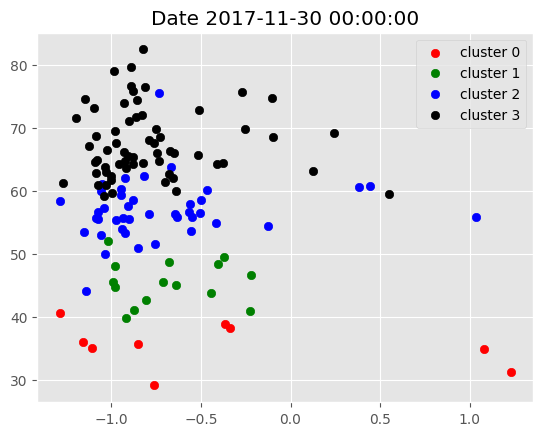

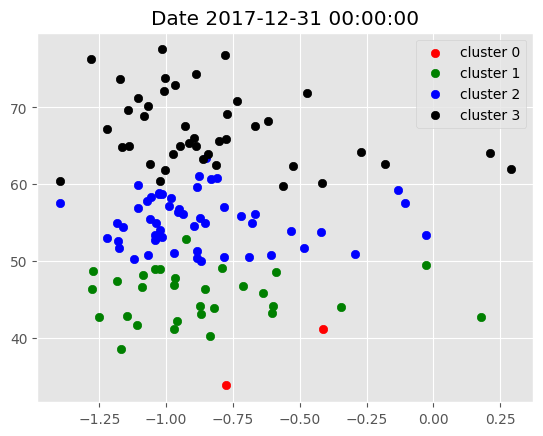

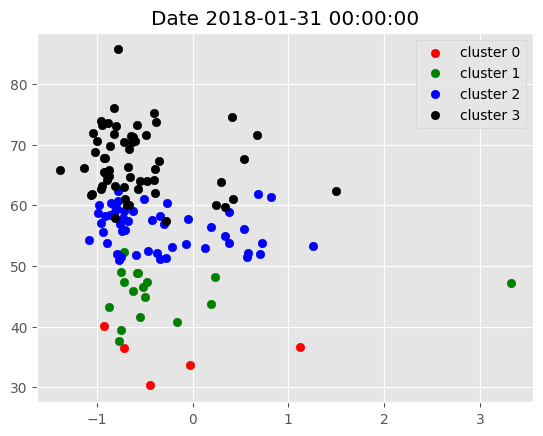

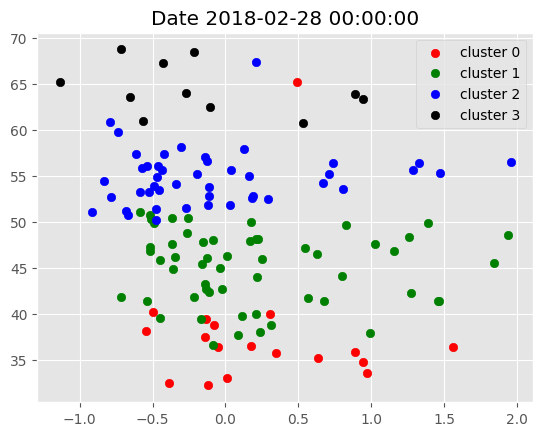

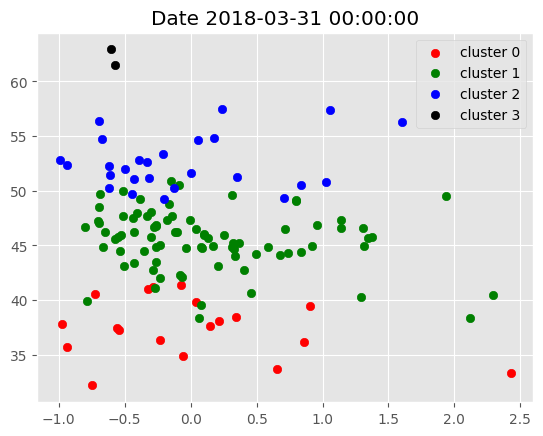

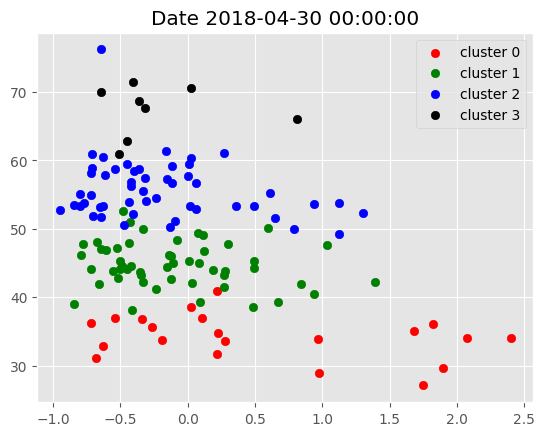

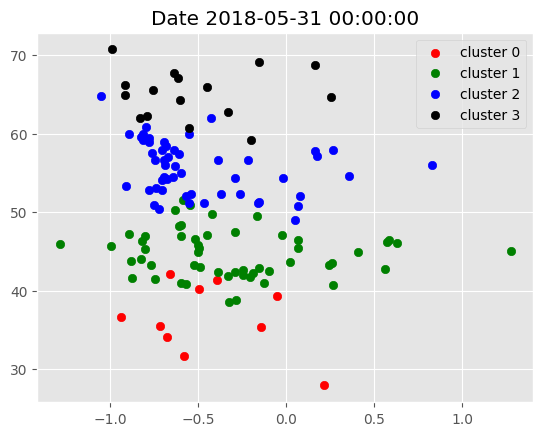

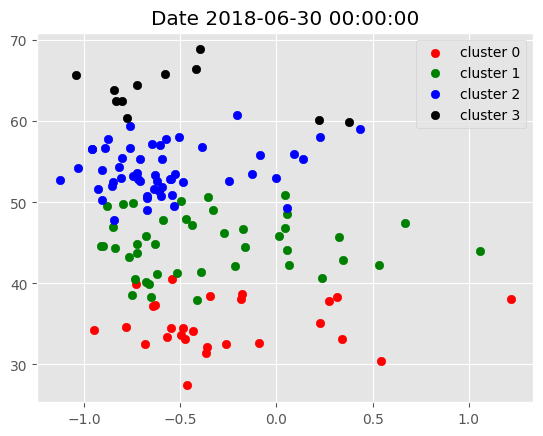

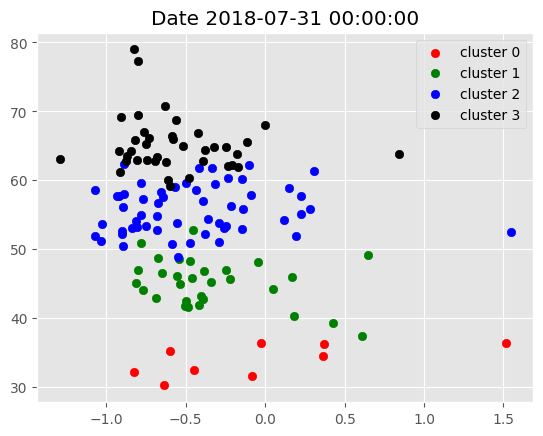

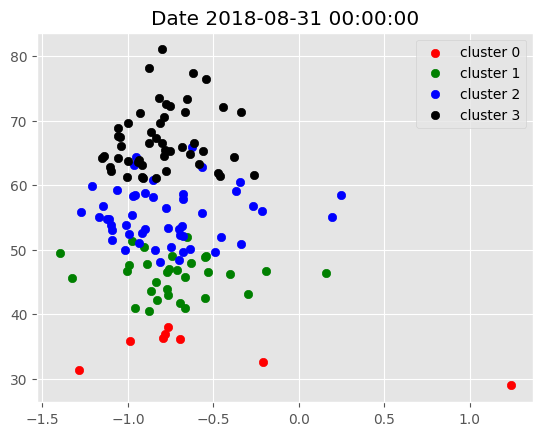

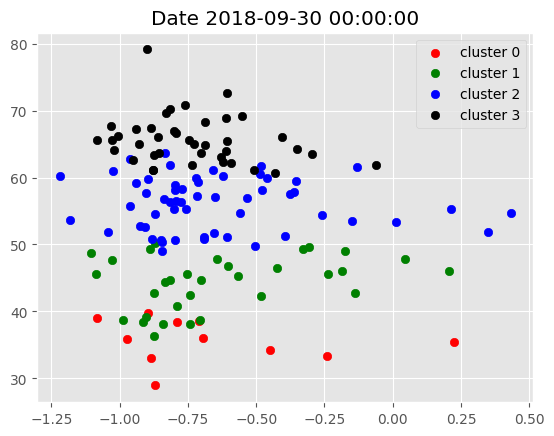

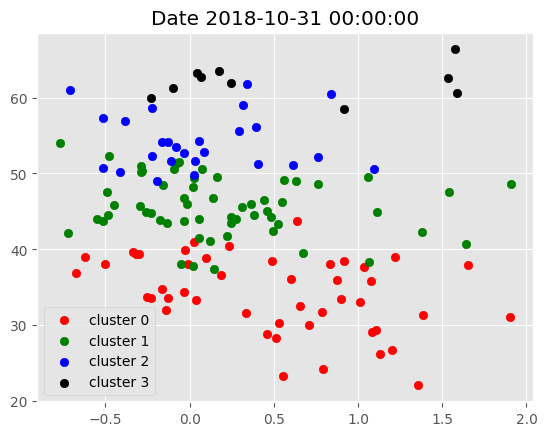

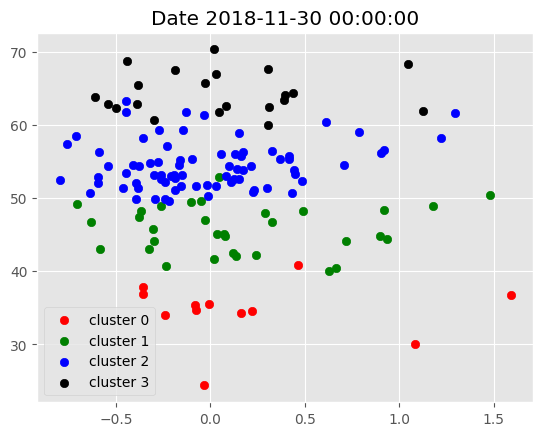

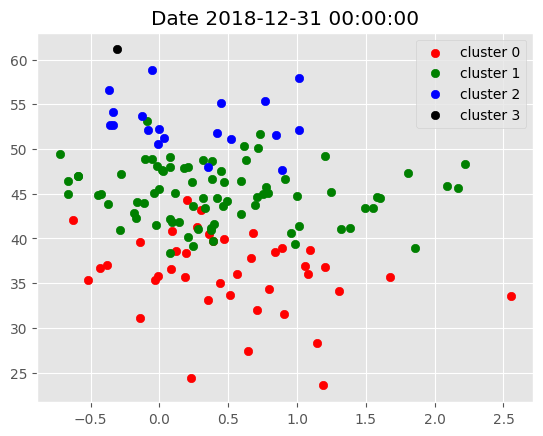

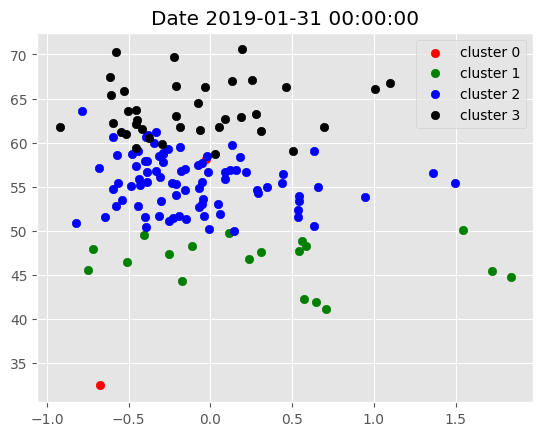

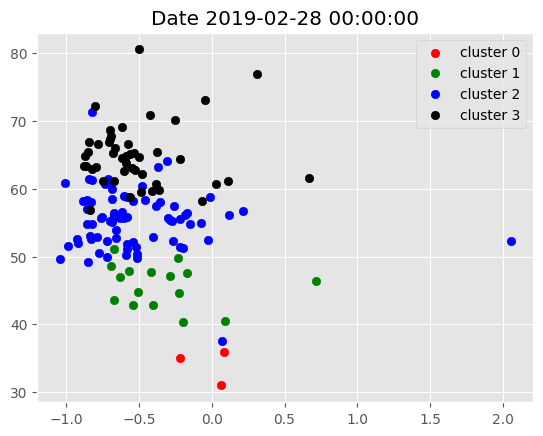

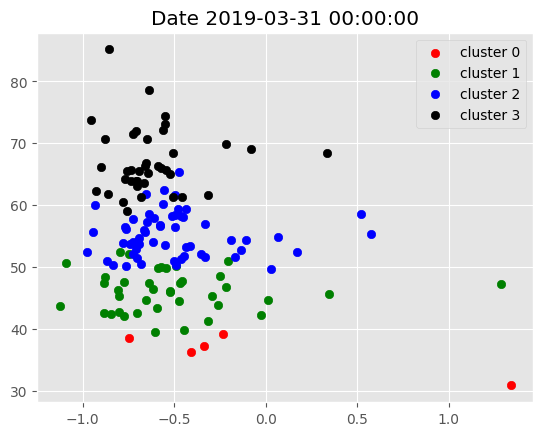

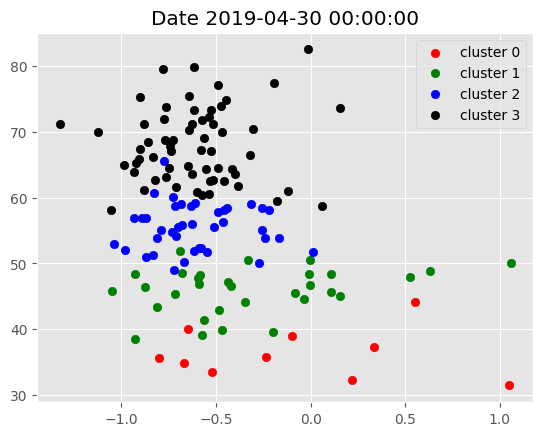

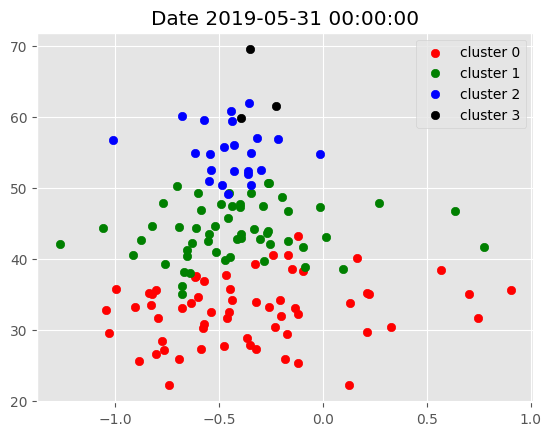

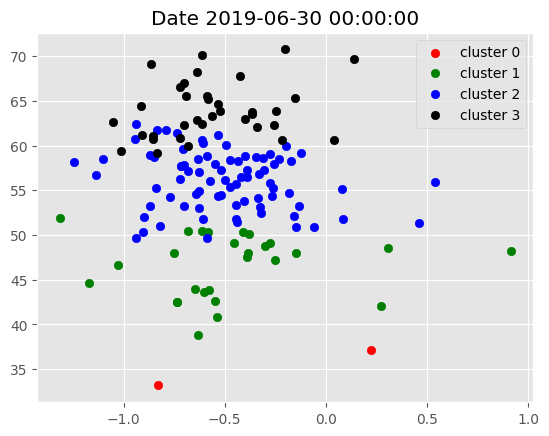

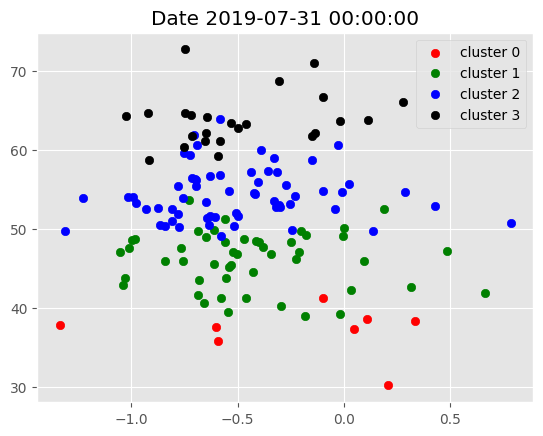

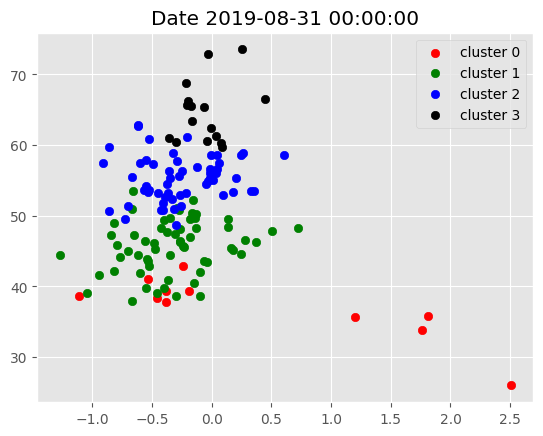

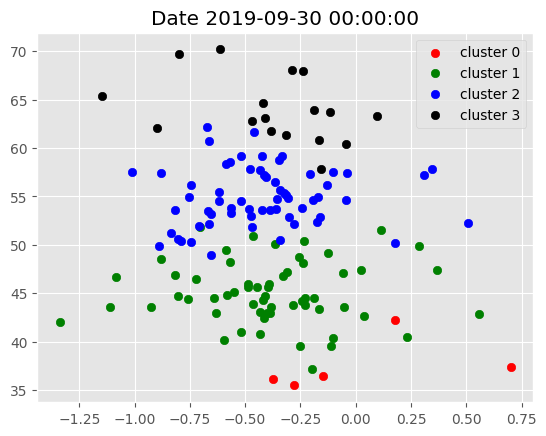

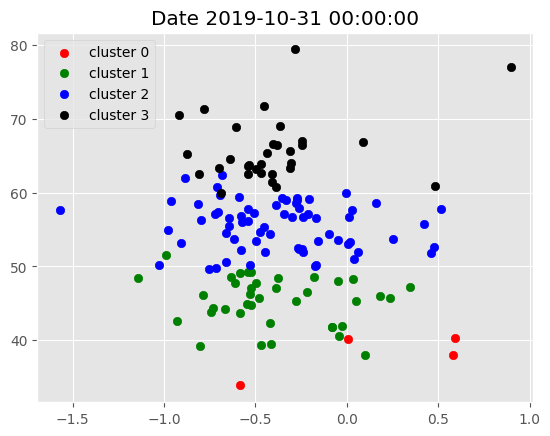

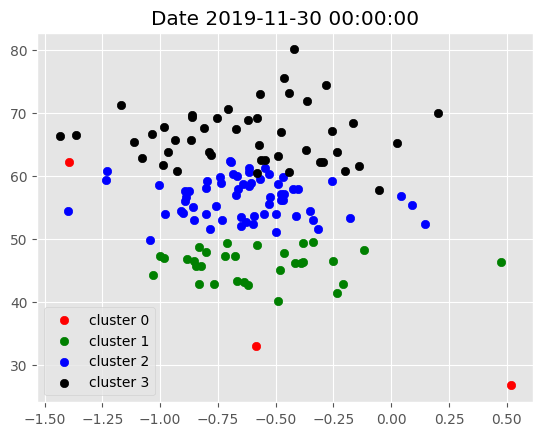

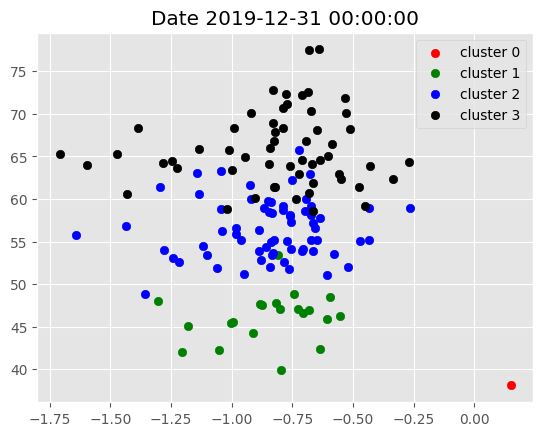

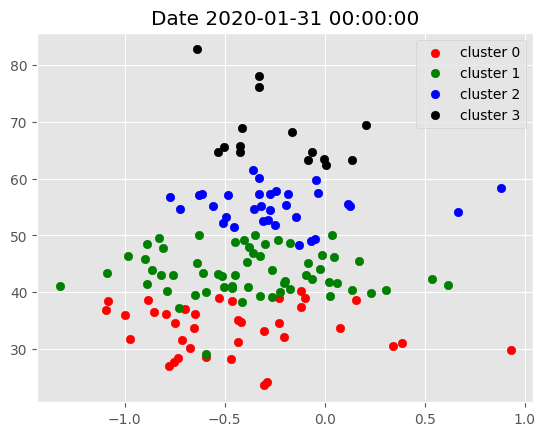

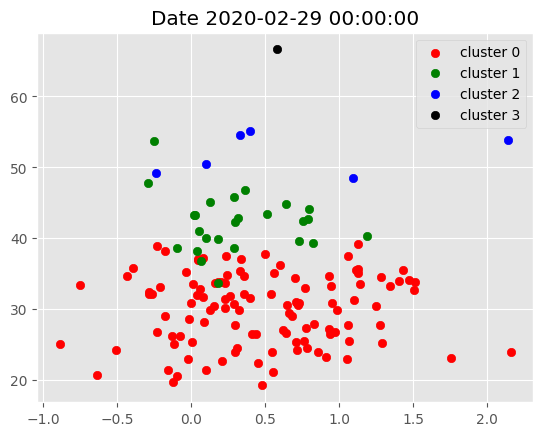

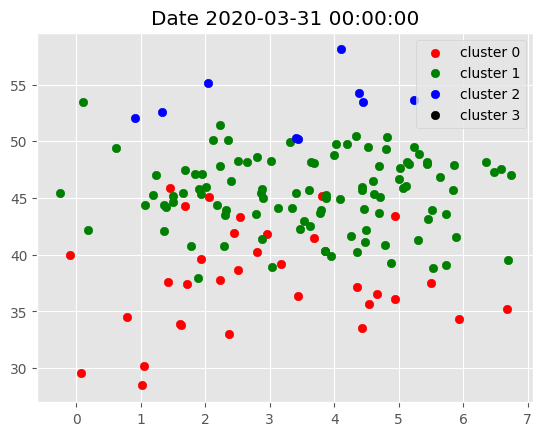

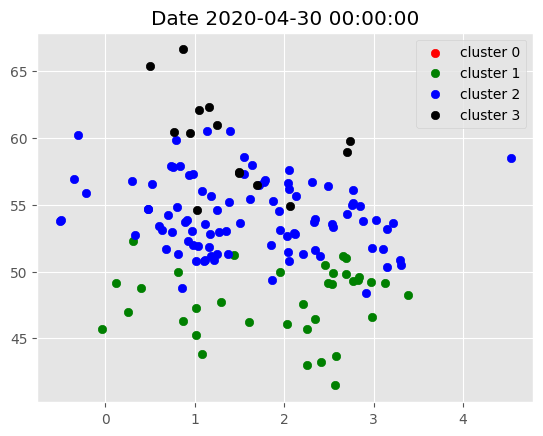

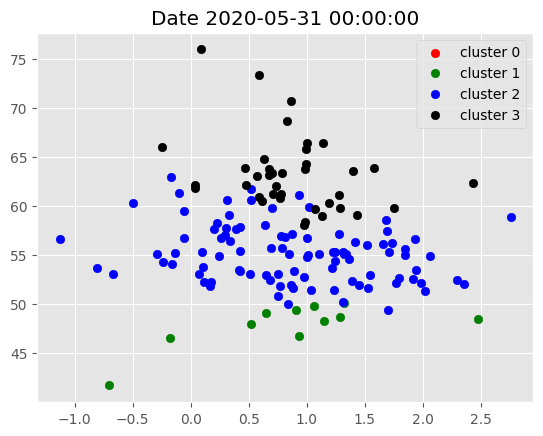

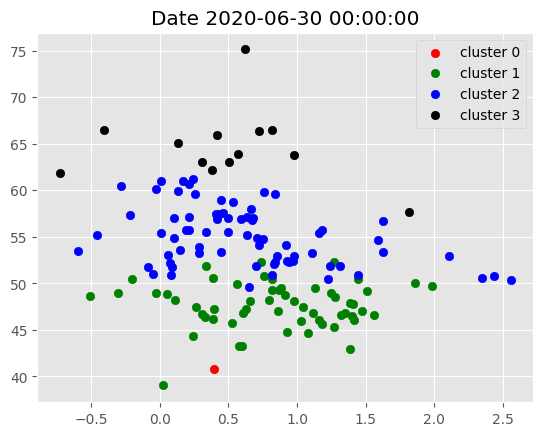

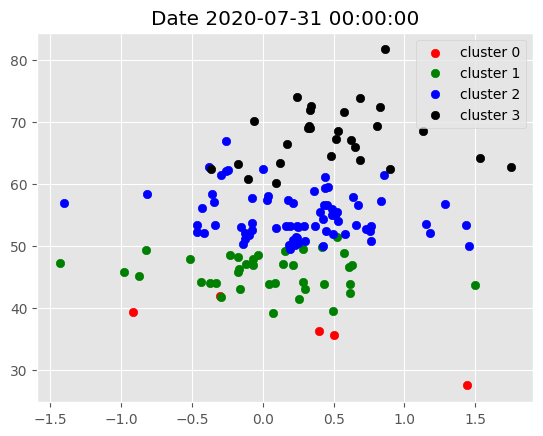

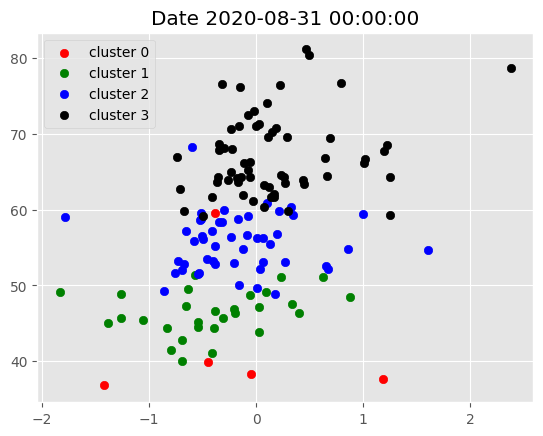

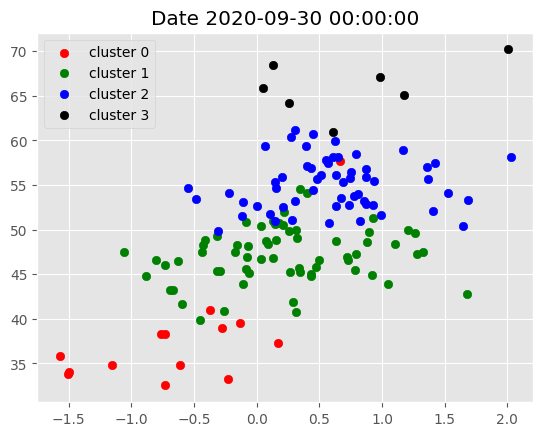

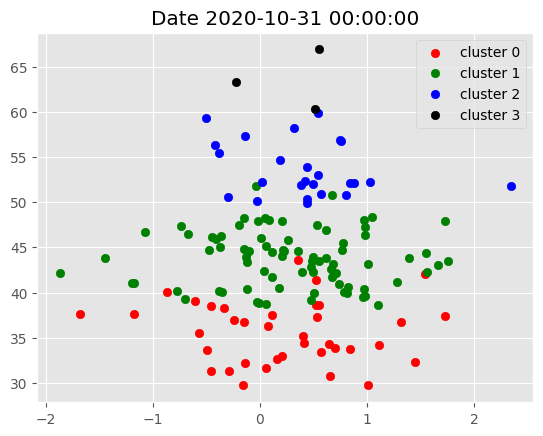

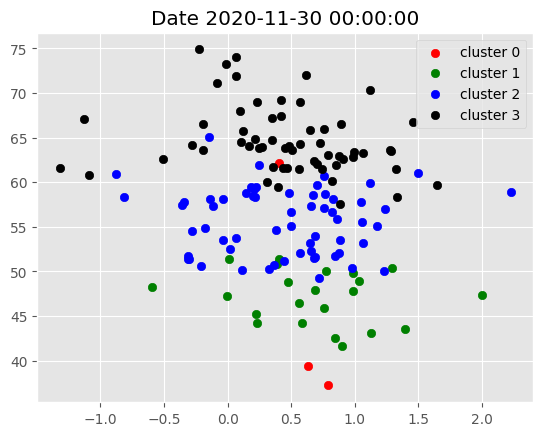

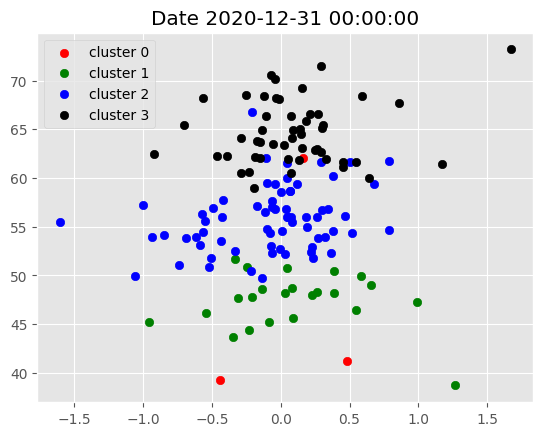

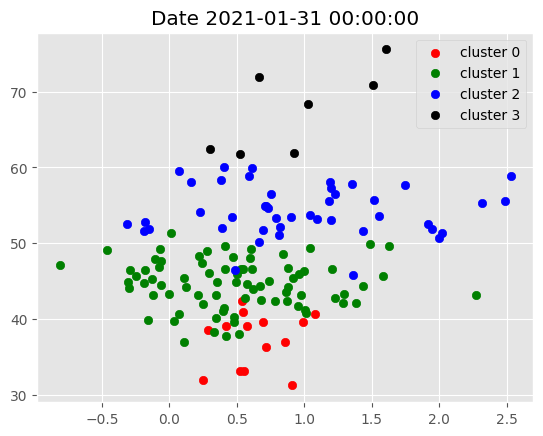

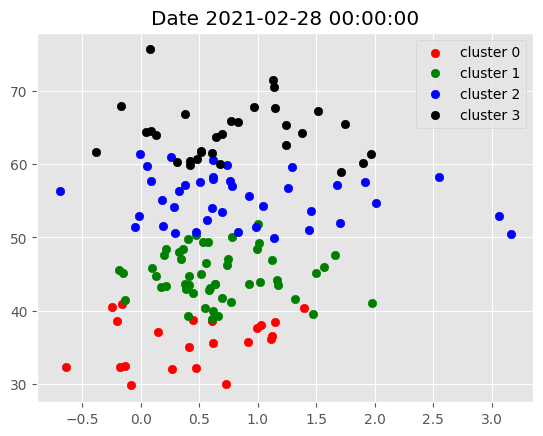

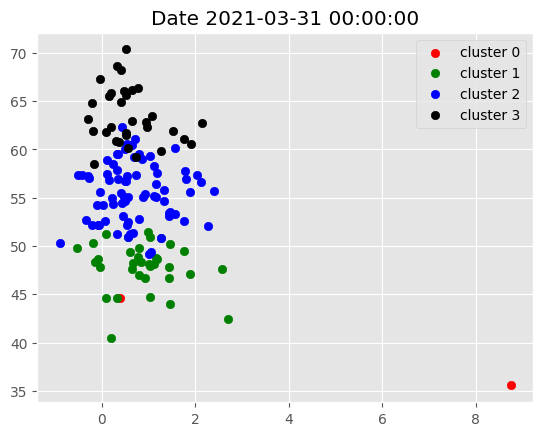

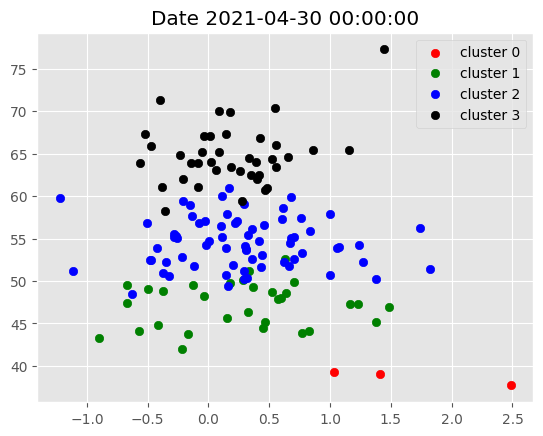

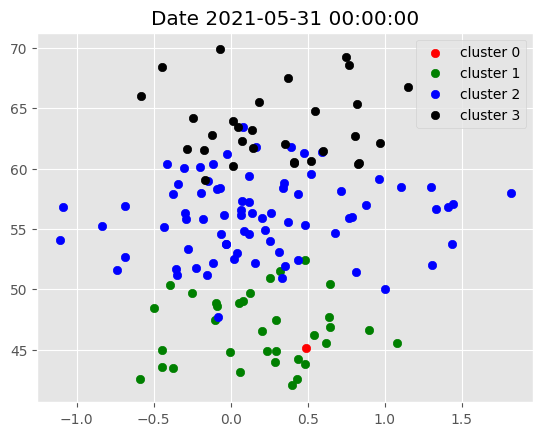

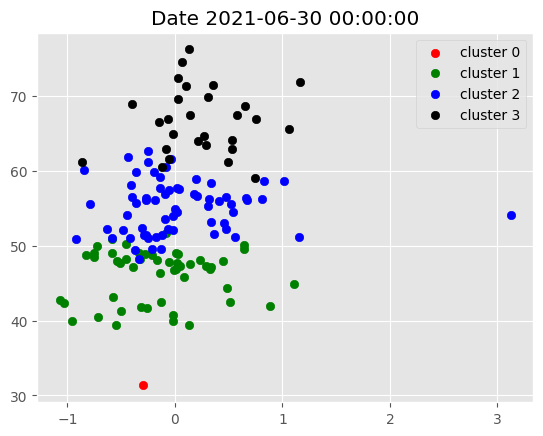

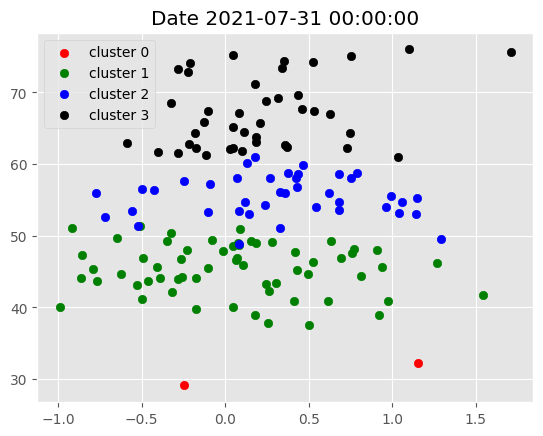

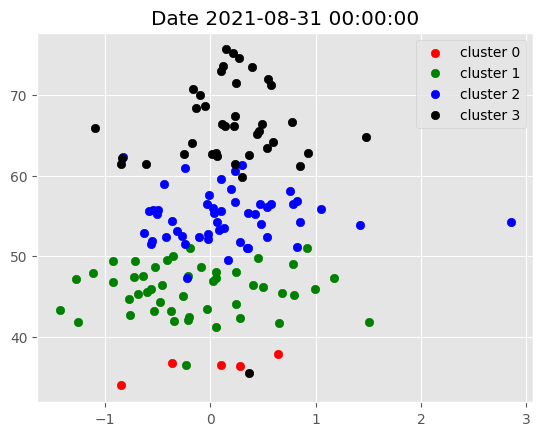

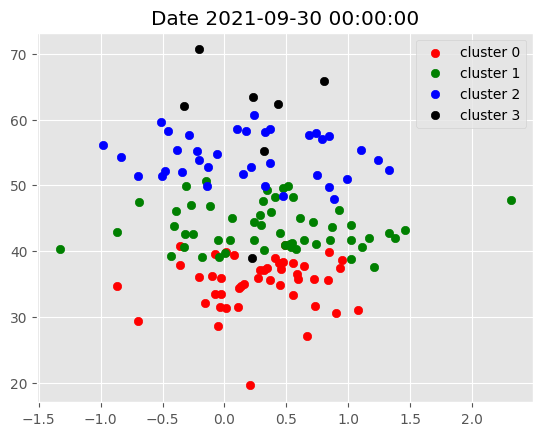

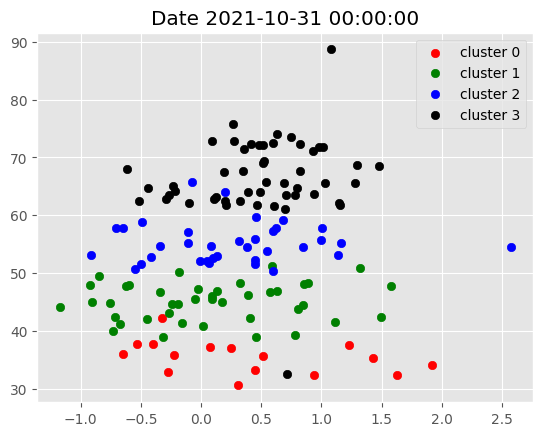

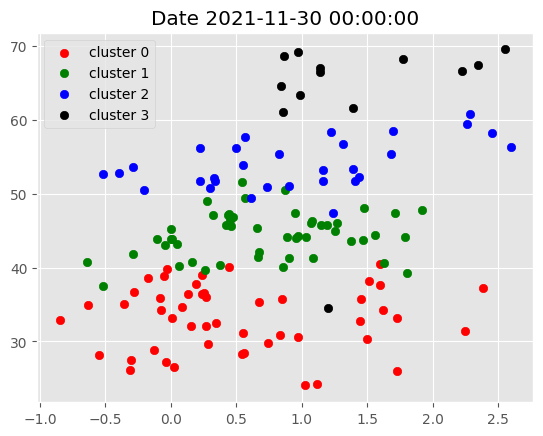

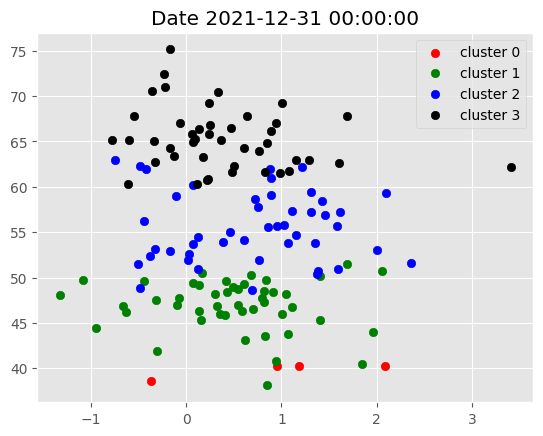

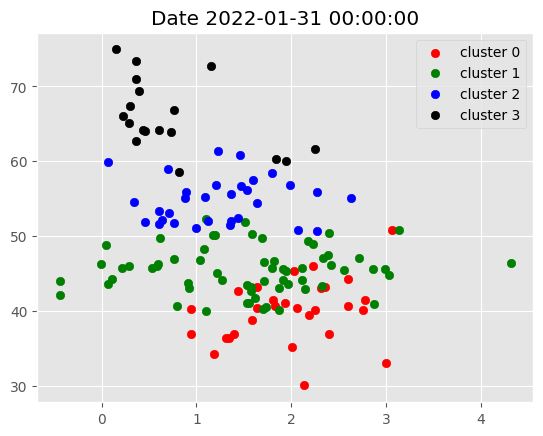

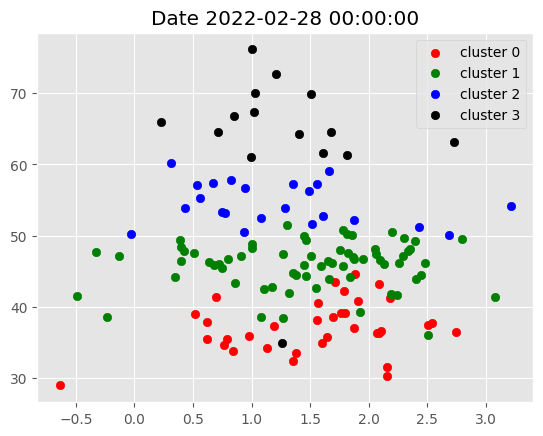

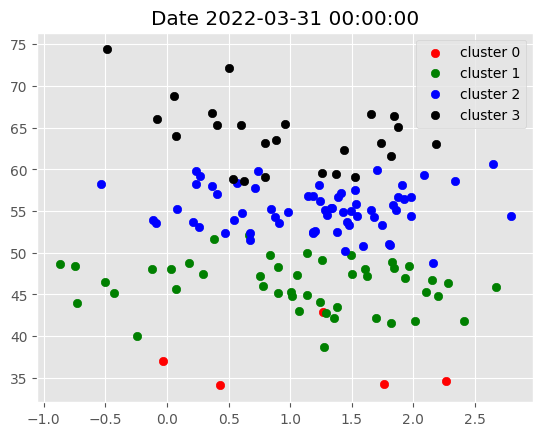

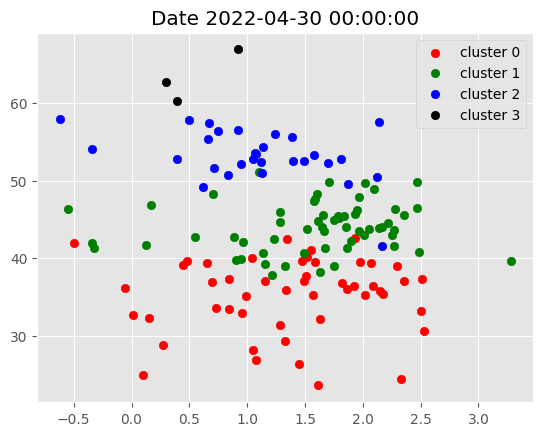

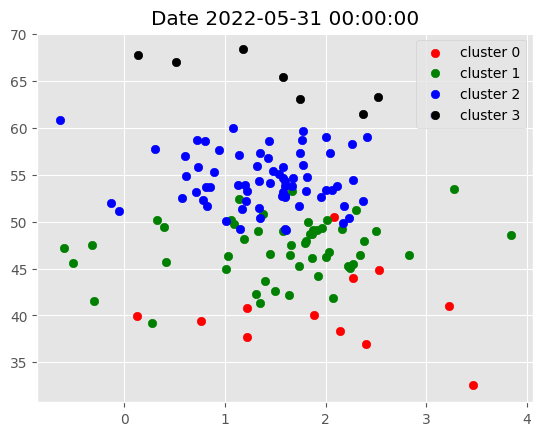

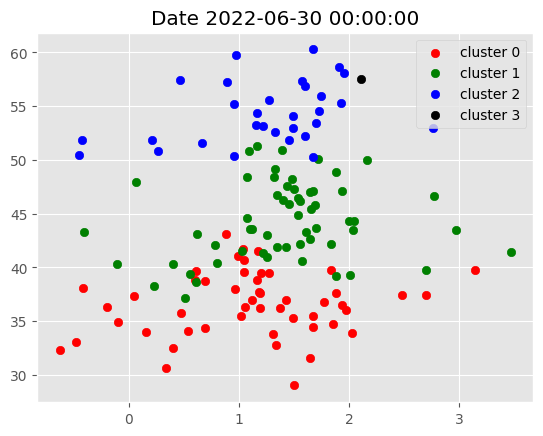

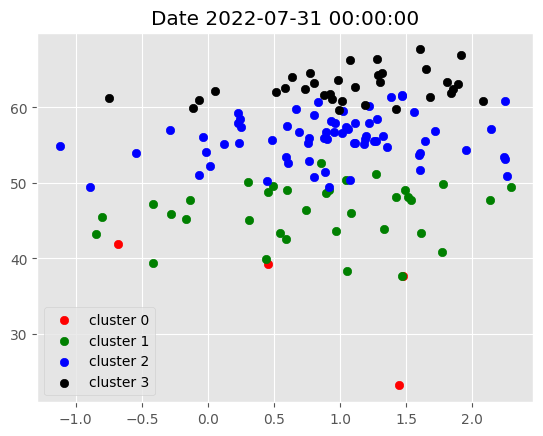

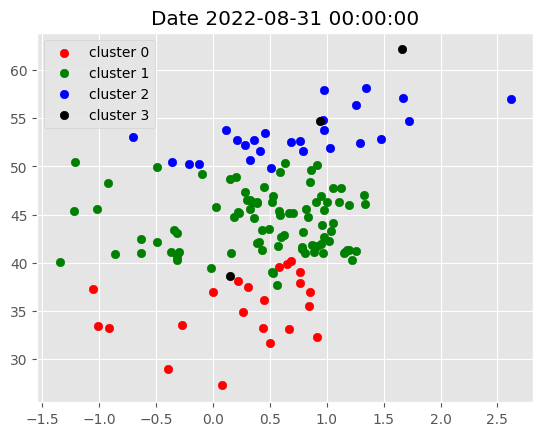

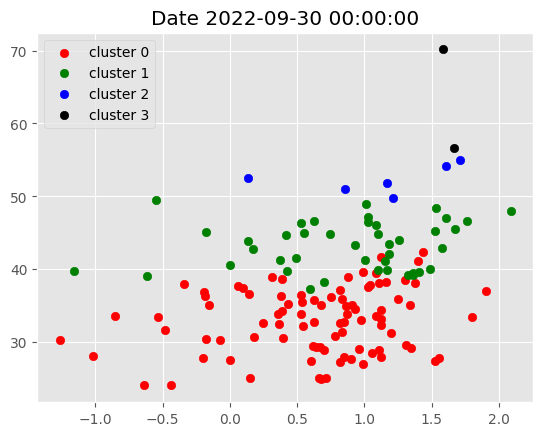

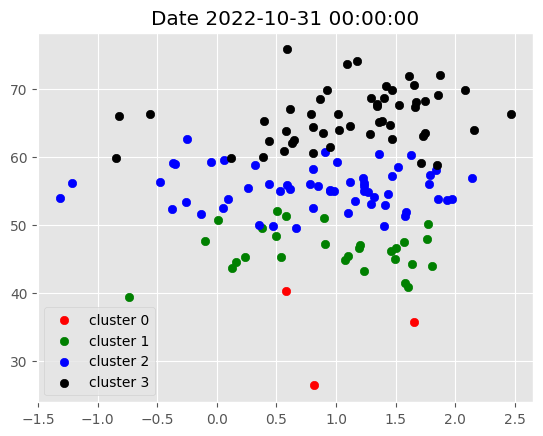

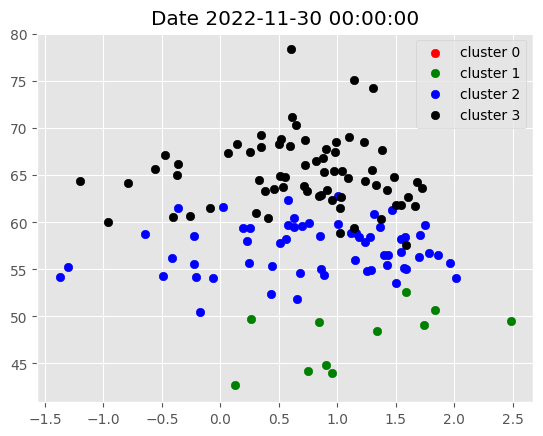

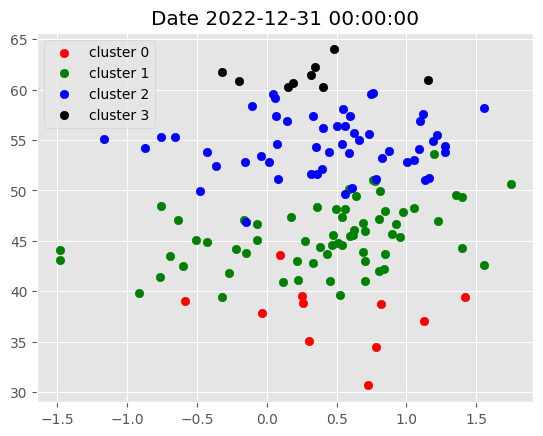

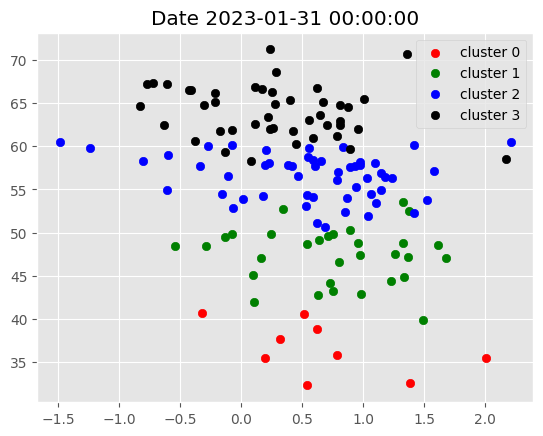

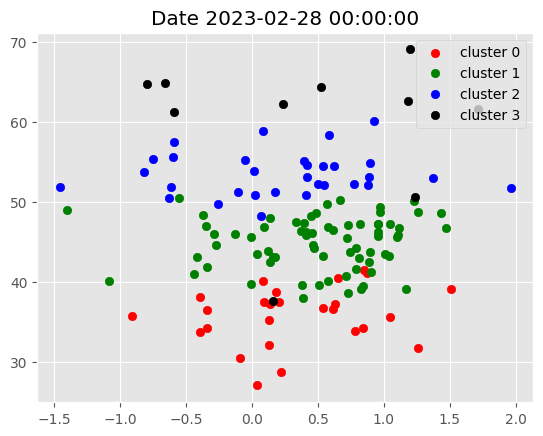

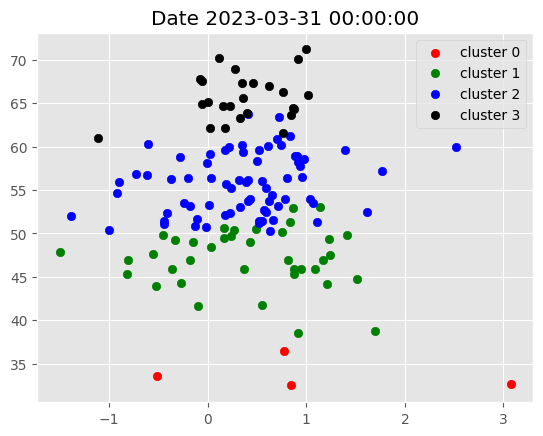

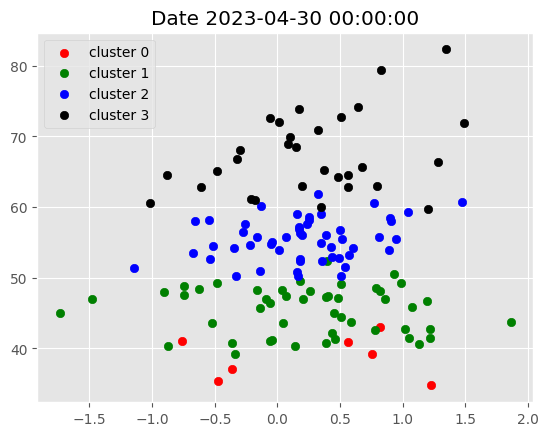

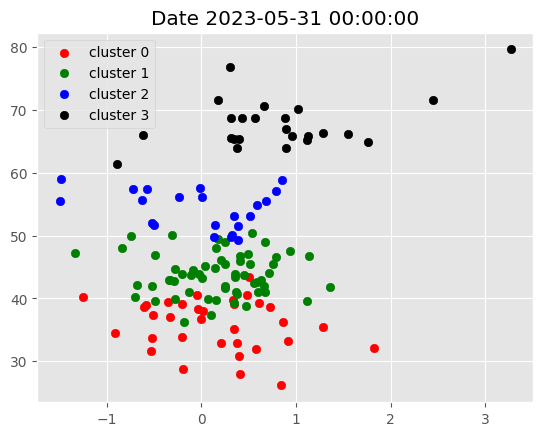

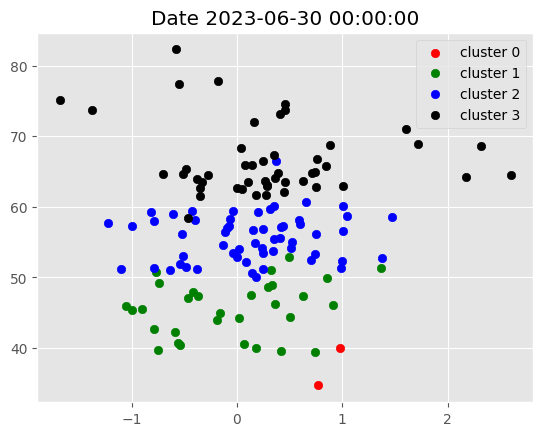

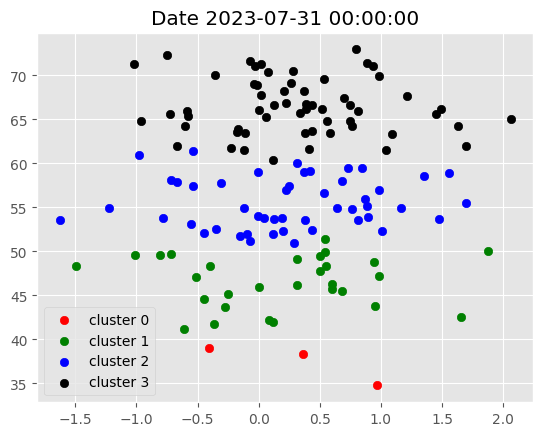

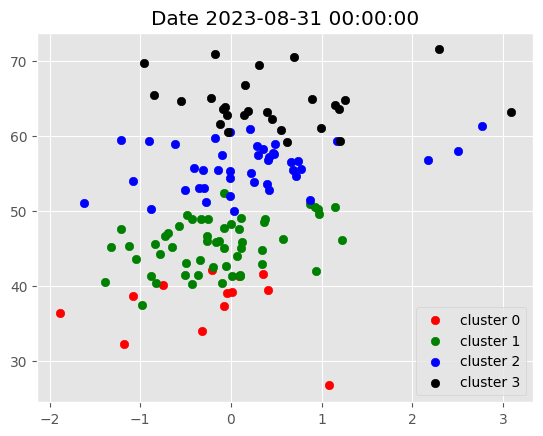

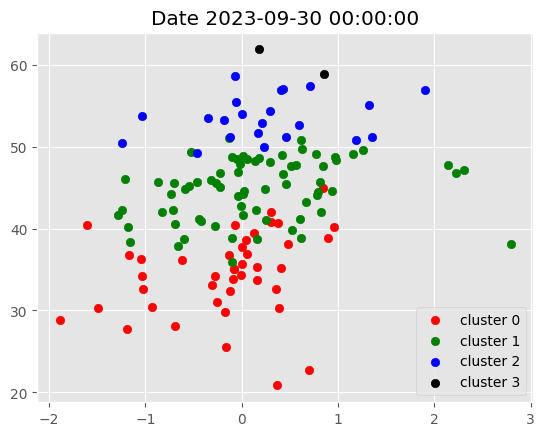

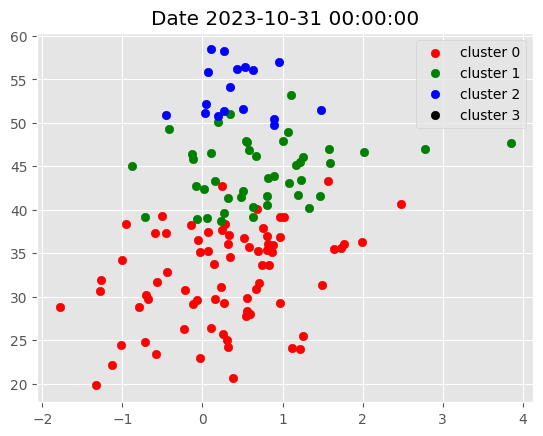

In [25]:
# Plotting the all clustering prediction based 'Month'
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

## Apply Pre-Defined Centroid

In [22]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:,6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

# For Each Month select assets based on the cluster and form a portfolio based on efficient Frontier max sharpe ratio optimization
* first we will filter only stocks corresponding to the cluster we choose based on our hypothesis
* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month-thus i would select stock corresponding to cluster 3.

In [26]:
# Just taking cluster '3'
filtered_df = data[data['cluster'] == 3].copy()

filtered_df = filtered_df.reset_index(level=1)

# +1 to date
filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()


fixed_dates = {}

for d in dates:
  fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2017-12-01': ['ABBV',
  'ACN',
  'AMZN',
  'AXP',
  'BA',
  'BAC',
  'BRK-B',
  'C',
  'CAT',
  'COST',
  'CSCO',
  'CSX',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'DHR',
  'DIS',
  'DLTR',
  'ELV',
  'F',
  'FDX',
  'HD',
  'HON',
  'IBM',
  'ILMN',
  'INTC',
  'ISRG',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MCD',
  'MET',
  'MMM',
  'MO',
  'MS',
  'MSFT',
  'NEE',
  'NKE',
  'ORLY',
  'OXY',
  'PEP',
  'PFE',
  'QCOM',
  'RTX',
  'SBUX',
  'SCHW',
  'SHW',
  'T',
  'TJX',
  'UAL',
  'UNH',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'VZ',
  'WFC',
  'WMT',
  'WYNN',
  'XOM'],
 '2018-01-01': ['ACN',
  'AXP',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COP',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'DLTR',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'INTC',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'MO',
  'NXPI',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'SCHW',
  'SLB',
  'STZ',
  'T',
  'TJX',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WFC',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABBV',
  'ABT',


# Define portfolio optimization function
* we will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio
* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.
* Apply single stock weights bonds constraing for diversification (minimum half of equaly weight and maximum 10% of portfolio)

In [27]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

  # calculate "Expected Return"
  returns = expected_returns.mean_historical_return(prices=prices,
                                          frequency=252)

  # Risk models
  cov = risk_models.sample_cov(prices=prices,
                               frequency=252)

  ef = EfficientFrontier(expected_returns=returns,
                     cov_matrix=cov,
                     weight_bounds=(lower_bound, .1),
                     solver='SCS')
  weights= ef.max_sharpe()

  return ef.clean_weights()


* download fresh daily prices data only for short listed stocks

In [28]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df =yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  154 of 154 completed


Adj Close                                                 \
                  AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-11-30  44.876503   25.747694   44.699745  33.597473  107.214005   
2016-12-01  44.209743   25.507730   43.494034  33.182686  105.625076   
2016-12-02  44.547958   25.603251   43.692532  33.447441  105.292915   
2016-12-05  44.180756   25.419207   44.743858  33.915180  105.678932   
2016-12-06  44.866848   25.614904   45.302605  33.906349  106.298347   
...               ...         ...         ...        ...         ...   
2023-10-24  11.210000  173.440002  146.309998  94.809998  296.089996   
2023-10-25  11.040000  171.100006  145.259995  93.570000  292.679993   
2023-10-26  11.150000  166.889999  145.199997  93.980003  292.040009   
2023-10-27  10.920000  168.220001  138.929993  92.849998  290.040009   
2023-10-30  11.180000  170.289993  141.889999  93.000000  292.700012   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-11-30  102.809998   82.871910   72.610001  52.607327   29.722994  ...   
2016-12-01   99.510002   82.656136   69.220001  53.255260   27.784536  ...   
2016-12-02   99.730003   82.198708   70.570000  52.956211   29.021456  ...   
2016-12-05  101.949997   82.897812   71.180000  53.346626   29.104534  ...   
2016-12-06  101.550003   82.854645   76.320000  53.597084   29.178379  ...   
...                ...         ...         ...        ...         ...  ...   
2023-10-24  539.559998  240.449997  205.039993  59.869999  134.899994  ...   
2023-10-25  521.140015  218.330002  200.210007  60.959999  130.110001  ...   
2023-10-26  514.280029  218.839996  196.119995  60.849998  130.839996  ...   
2023-10-27  508.119995  214.839996  195.149994  59.529999  131.300003  ...   
2023-10-30  526.940002  216.080002  197.789993  61.000000  131.029999  ...   

              Volume                                                   \
                   V       VLO     VRTX        VZ       WBA       WDC   
Date                                                                    
2016-11-30  15353900  14238400  2292700  20698900   5951900   5383000   
2016-12-01  21053000  10720500  2662600  12982800   4463500   5508400   
2016-12-02  13629600   5295700  4580500  10650700   3928600   3496900   
2016-12-05  12119200   8277900  2588600  13074700   2800200   6865600   
2016-12-06  13896600   5149300  1816700  13581500   2911400   5049500   
...              ...       ...      ...       ...       ...       ...   
2023-10-24   6844100   2913400   997300  61617900  10157700   4314300   
2023-10-25  10365300   3056200   958000  30832800  10408400   2764400   
2023-10-26   6414500   3992500   942100  34367000   8832500  17872200   
2023-10-27   5540900   3674500   910700  23924800   9208600   6533300   
2023-10-30   5170300   2925400   872400  31497700   9239900  16960100   

                                                   
                 WFC       WMT     WYNN       XOM  
Date                                               
2016-11-30  26567200   9326100  2618300  22696200  
2016-12-01  35623100   6849800  3881900  13005600  
2016-12-02  21894700   6674200  1955500   9706600  
2016-12-05  24793900  10527900  1678600  11741100  
2016-12-06  30706700   7778000  2892100  11293600  
...              ...       ...      ...       ...  
2023-10-24  15097800   5845000  1335000  16786100  
2023-10-25  13849000   5540600  1518500  22047300  
2023-10-26  15480300   5406700  2183400  18768300  
2023-10-27  13582800   4609900  1587500  23092000  
2023-10-30  14141900   4217900  1343100  19379900  

[1740 rows x 924 columns]

* Calculate daily returns for each stock which could land up in our portfolio
* Then loop over each month start, select the stocks for the month and calculate their weights for next month.
* If the maximum sharpe ratio optimization fails for a given month, apply equaly-weighted weight.
* Calculated each day portfolio return.

In [29]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights

,Strategy Return
date,
2017-12-01,-0.004922
2017-12-04,-0.004511
2017-12-05,-0.002812
2017-12-06,0.002636
2017-12-07,0.004881
...,...
2023-10-24,0.000706
2023-10-25,-0.006301
2023-10-26,-0.009101


# Visualize Portfolio Return and Compare to SP500 returns.

In [30]:
spy = yf.download(tickers='SPY',
            start='2015-01-01',
            end=dt.date.today())

[*********************100%%**********************]  1 of 1 completed


In [31]:
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'Spy Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

,Strategy Return,Spy Buy&Hold
2017-12-01,-0.004922,-0.002078
2017-12-04,-0.004511,-0.001211
2017-12-05,-0.002812,-0.003603
2017-12-06,0.002636,0.000190
2017-12-07,0.004881,0.003148
...,...,...
2023-10-24,0.000706,0.007511
2023-10-25,-0.006301,-0.014456
2023-10-26,-0.009101,-0.012047
2023-10-27,-0.024941,-0.004543


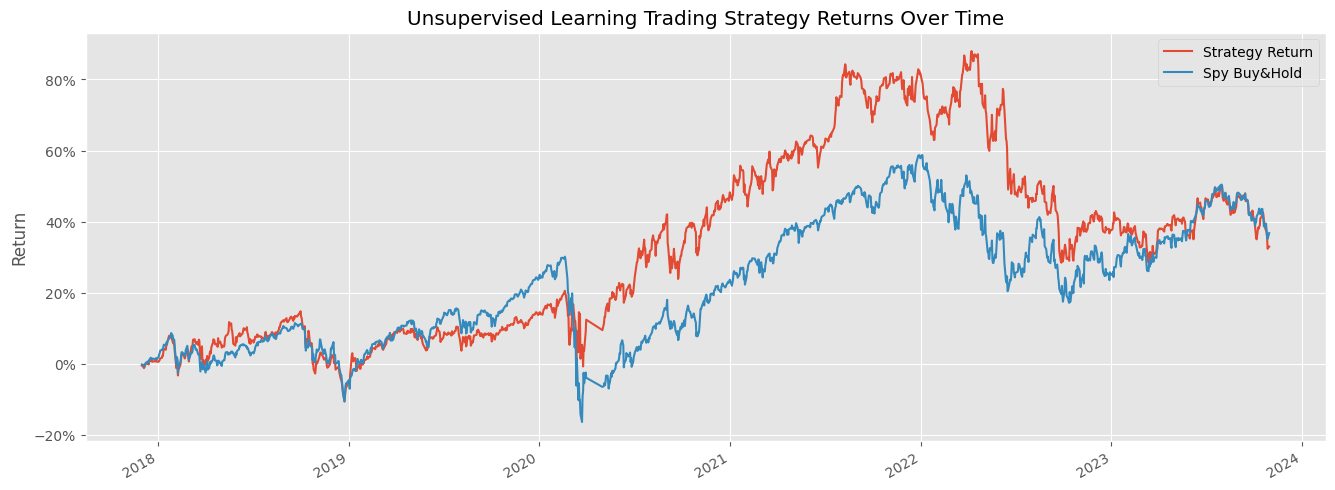

In [32]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return[:'2023-11-07'].plot(figsize=(16,6))
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()